In [25]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write
import ase.io as io
from ase.visualize import view

atoms = io.read(r'C:\Users\Joshu\OneDrive\Desktop\For python\Models\Ceria.cfg')

In [26]:
view(atoms)

<Popen: returncode: None args: ['C:\\Users\\Joshu\\anaconda3\\envs\\myenv\\p...>

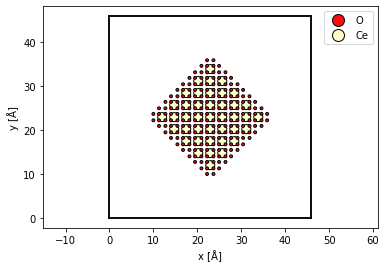

In [27]:
abtem.show_atoms(
    atoms,
    plane="xy",  # show a view perpendicular to the 'xy' plane
    scale=0.5,  # scale atoms to 0.5 of their covalent radii; default is 0.75
    legend=True,  # show a legend with the atomic symbols
);

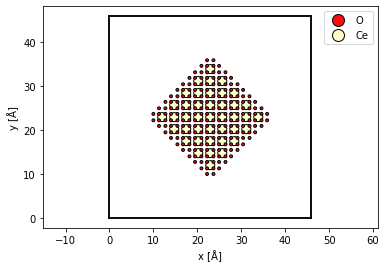

In [29]:
abtem.show_atoms(
    atoms,
    show_periodic=True,
    scale=0.5,
    legend=True,
);

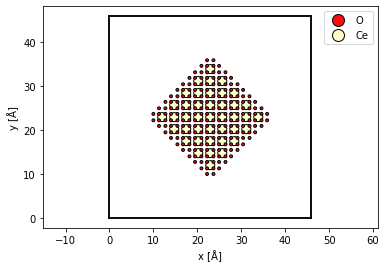

In [30]:
centered_atoms = atoms.copy()
centered_atoms.center()

abtem.show_atoms(
    centered_atoms,
    scale=0.5,
    legend=True,
);

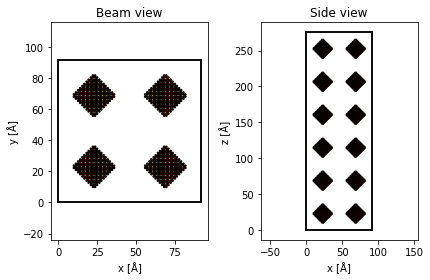

In [31]:
repeated_atoms = atoms * (2, 2, 6)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(repeated_atoms, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_atoms, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

In [1]:
print("hello")

hello
